# Step 1: Model specification (choice of problem formulation)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.1.3
2.5.1


In [3]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)
from dike_model_function import DikeNetwork  # @UnresolvedImport


def sum_over(*args):
    return sum(args)

In [4]:
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation


ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation
dike_model, planning_steps = get_model_for_problem_formulation(10)

In [5]:
#enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter),
#lower boundary, and upper boundary
for unc in dike_model.uncertainties:
    print(repr(unc))
    
uncertainties = dike_model.uncertainties

import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132)
RealParameter('A.1_Bmax', 30, 350)
RealParameter('A.1_pfail', 0, 1)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350)
RealParameter('A.2_pfail', 0, 1)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350)
RealParameter('A.3_pfail', 0, 1)
CategoricalParameter('A.3_Brate', [0, 1, 2])
RealParameter('A.4_Bmax', 30, 350)
RealParameter('A.4_pfail', 0, 1)
CategoricalParameter('A.4_Brate', [0, 1, 2])
RealParameter('A.5_Bmax', 30, 350)
RealParameter('A.5_pfail', 0, 1)
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [6]:
#enlisting policy levers, their types (RealParameter/IntegerParameter),
#lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))
    
levers = dike_model.levers 

import copy
levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1)
IntegerParameter('0_RfR 1', 0, 1)
IntegerParameter('0_RfR 2', 0, 1)
IntegerParameter('1_RfR 0', 0, 1)
IntegerParameter('1_RfR 1', 0, 1)
IntegerParameter('1_RfR 2', 0, 1)
IntegerParameter('2_RfR 0', 0, 1)
IntegerParameter('2_RfR 1', 0, 1)
IntegerParameter('2_RfR 2', 0, 1)
IntegerParameter('3_RfR 0', 0, 1)
IntegerParameter('3_RfR 1', 0, 1)
IntegerParameter('3_RfR 2', 0, 1)
IntegerParameter('4_RfR 0', 0, 1)
IntegerParameter('4_RfR 1', 0, 1)
IntegerParameter('4_RfR 2', 0, 1)
IntegerParameter('EWS_DaysToThreat', 0, 4)
IntegerParameter('A.1_DikeIncrease 0', 0, 10)
IntegerParameter('A.1_DikeIncrease 1', 0, 10)
IntegerParameter('A.1_DikeIncrease 2', 0, 10)
IntegerParameter('A.2_DikeIncrease 0', 0, 10)
IntegerParameter('A.2_DikeIncrease 1', 0, 10)
IntegerParameter('A.2_DikeIncrease 2', 0, 10)
IntegerParameter('A.3_DikeIncrease 0', 0, 10)
IntegerParameter('A.3_DikeIncrease 1', 0, 10)
IntegerParameter('A.3_DikeIncrease 2', 0, 10)
IntegerParameter('A.4_DikeIncreas

In [7]:
#enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1_Dike Investment Costs', variable_name=['A.1_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2'], function=<function sum_over at 0x7fabda41fd08>)
ScalarOutcome('A.1_Expected Annual Damage', variable_name=['A.1_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2'], function=<function sum_over at 0x7fabda41fd08>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=['A.1_Expected Number of Deaths 0', 'A.1_Expected Number of Deaths 1', 'A.1_Expected Number of Deaths 2'], function=<function sum_over at 0x7fabda41fd08>)
ScalarOutcome('A.2_Dike Investment Costs', variable_name=['A.2_Dike Investment Costs 0', 'A.2_Dike Investment Costs 1', 'A.2_Dike Investment Costs 2'], function=<function sum_over at 0x7fabda41fd08>)
ScalarOutcome('A.2_Expected Annual Damage', variable_name=['A.2_Expected Annual Damage 0', 'A.2_Expected Annual Damage 1', 'A.2_Expected Annual Damage 2'], function=<function sum_o

# Step 2: MORDM
## (Step 2.1: model specification done above)
## Step 2.2:  find candidate solutions 

This step consists of the following actions:
- search for candidate solutions through optimization
- visualize the convergence of the algorithm (hypervolume and epsilon progress)
- visalize the trade-offs in outcomes for all candidate solutions


In [13]:
#--- Search for candidate solutions through optimization
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
convergence_metrics = [HyperVolume(minimum=[0,0,0,0], maximum=[3, 2,1,1]),
                       EpsilonProgress()]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=5000, searchover='levers',
                                 convergence=convergence_metrics,
                                 epsilons=[0.01,]*len(dike_model.outcomes))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 495/5000 nfe
[MainProcess/INFO] generation 10: 993/5000 nfe
[MainProcess/INFO] generation 15: 1492/5000 nfe
[MainProcess/INFO] generation 20: 1991/5000 nfe
[MainProcess/INFO] generation 25: 2490/5000 nfe
[MainProcess/INFO] generation 30: 2988/5000 nfe
[MainProcess/INFO] generation 35: 3488/5000 nfe
[MainProcess/INFO] generation 40: 3987/5000 nfe
[MainProcess/INFO] generation 45: 4486/5000 nfe
[MainProcess/INFO] generation 50: 4985/5000 nfe
[MainProcess/INFO] optimization completed, found 59 solutions
[MainProcess/INFO] terminating pool


In [ ]:
#--- Visualizing convergence
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,7))
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

   A.3_Expected Annual Damage  A.3_Expected Number of Deaths  \
0                0.000000e+00                       0.000000   
1                2.083866e+08                       0.375415   

   Expected Evacuation Costs  
0                   0.000000  
1               13574.727003  


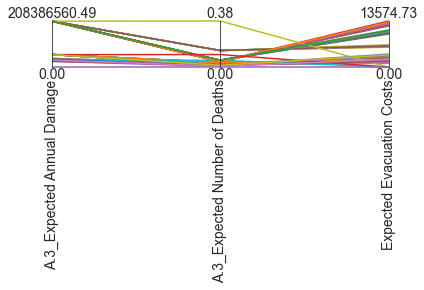

In [14]:
#--- Visualize trade-offs in the outcomes for all candidate solutions
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

data = results.loc[:, [o for o in ['A.3_Expected Annual Damage', 'A.3_Expected Number of Deaths', 'Expected Evacuation Costs']]]
limits = parcoords.get_limits(data)
print(limits)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

# Step 2.3: Re-evaluating candidate solutions under uncertainty
This step consists of the following actions:
- Run experiments for all candidate solutions that meet certain criteria (here: expected annual damage in Zutphen under €100M
- Score the outcomes by their signal-to-noise ratio
- Visualize the scores for Zutphen's outcomes

In [15]:
#--- Run experiments on candidate solutions

# Filter for solutions with annual damage under EUR 100M 
logical = results['A.3_Expected Annual Damage'] < 1e8
np.sum(logical)
policies = results[logical]
policies = policies.drop([o for o in ['A.3_Expected Annual Damage', 'A.3_Expected Number of Deaths', 'Expected Evacuation Costs']], axis=1)
policies

from ema_workbench import Policy

# Create list of policies to evaluate
policies_to_evaluate = []
for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
n_scenarios = 100

# Run experiments
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 31 policies * 1 model(s) = 3100 experiments
[MainProcess/INFO] 310 cases completed
[MainProcess/INFO] 620 cases completed
[MainProcess/INFO] 930 cases completed
[MainProcess/INFO] 1240 cases completed
[MainProcess/INFO] 1550 cases completed
[MainProcess/INFO] 1860 cases completed
[MainProcess/INFO] 2170 cases completed
[MainProcess/INFO] 2480 cases completed
[MainProcess/INFO] 2790 cases completed
[MainProcess/INFO] 3100 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [16]:
#--- Defining a function for signal-to-noise ratio calculation

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [17]:
#--- Applying the function to our results
import pandas as pd
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1_Dike Investment Costs,A.1_Expected Annual Damage,A.1_Expected Number of Deaths,A.2_Dike Investment Costs,A.2_Expected Annual Damage,A.2_Expected Number of Deaths,A.3_Dike Investment Costs,A.3_Expected Annual Damage,A.3_Expected Number of Deaths,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
13,5.436836,0.000000e+00,0.000000e+00,11.331128,4.524992e+14,7.560510e-06,0.000000,3.789858e+15,0.000253,0.599266,9.983970e+08,2.627223e-12,5.130831,5.763096e+11,1.883809e-08,0.0,1.214627e+07
14,0.000000,0.000000e+00,0.000000e+00,5.643857,4.710922e+14,4.533838e-05,0.000000,3.789361e+15,0.001456,1.006706,9.983970e+08,1.513280e-11,1.965004,1.718081e+10,4.011988e-09,0.0,4.386649e+06
18,33.916757,0.000000e+00,0.000000e+00,1.476223,1.481761e+15,1.423459e-04,0.165163,1.670062e+15,0.000649,0.193400,2.595275e+10,3.943743e-10,3.336454,4.735150e+11,8.667988e-08,0.0,3.927635e+06
21,0.000000,0.000000e+00,0.000000e+00,4.949312,1.370686e+15,1.305325e-04,0.165163,1.964508e+15,0.000765,0.000000,1.228829e+10,1.968335e-10,1.934530,1.308993e+13,2.097055e-06,0.0,4.362543e+06
22,12.210110,2.343419e+10,4.747978e-10,0.000000,1.240795e+15,2.019516e-05,0.000000,3.779017e+15,0.000252,0.769917,0.000000e+00,0.000000e+00,0.000000,8.973570e+11,2.631890e-08,0.0,1.643139e+07
25,17.628410,0.000000e+00,0.000000e+00,1.764705,1.245689e+15,1.169157e-04,0.000000,3.779017e+15,0.001451,0.278645,8.621934e+09,1.230295e-10,0.000000,0.000000e+00,0.000000e+00,0.0,5.906255e+06
27,0.000000,0.000000e+00,0.000000e+00,1.476223,5.141406e+15,7.944357e-05,0.000000,3.659372e+15,0.000245,0.317641,9.983970e+08,2.627223e-12,0.000000,5.679384e+11,1.858632e-08,0.0,2.825974e+07
28,0.000000,0.000000e+00,0.000000e+00,1.856295,1.421895e+15,2.350492e-05,0.165163,1.670384e+15,0.000113,0.280582,4.177987e+11,1.040381e-09,1.734504,2.877624e+11,1.049960e-08,0.0,1.068975e+07
29,9.930409,0.000000e+00,0.000000e+00,1.699713,3.253738e+15,2.920211e-04,0.000000,3.671698e+15,0.001419,1.589539,0.000000e+00,0.000000e+00,4.274388,1.382475e+11,3.163485e-08,0.0,8.121326e+06
31,5.920409,0.000000e+00,0.000000e+00,1.699713,3.253738e+15,5.069810e-05,0.000000,3.671698e+15,0.000246,1.006706,9.983970e+08,2.627223e-12,4.119255,1.382475e+11,5.492161e-09,0.0,2.238670e+07


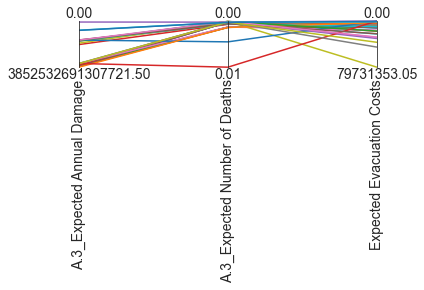

In [18]:
#--- Visualizing the scores for Zutphen's outcomes

experiments, outcomes = results

data = scores.loc[:, [o for o in ['A.3_Expected Annual Damage', 'A.3_Expected Number of Deaths', 'Expected Evacuation Costs']]]
limits = parcoords.get_limits(data)
limits.loc[0, ['A.3_Expected Annual Damage', 'A.3_Expected Number of Deaths', 'Expected Evacuation Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(['A.3_Expected Annual Damage', 'A.3_Expected Number of Deaths', 'Expected Evacuation Costs'])
plt.show()

# Step 2.4 Scenario discovery

In [26]:
#--- Applying scenario discovery focusing on annual damage > EUR 1M
from ema_workbench.analysis import prim

outcomesZutphen = experiments[['A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.3_Dike Investment Costs',
                              'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
                              'EWS_DaysToThreat']]

x = outcomesZutphen
y = outcomes['A.3_Expected Annual Damage'] > 1e6
prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()
box.inspect_tradeoff()

[MainProcess/INFO] 3100 points remaining, containing 525 cases of interest
[MainProcess/INFO] mean: 0.9895833333333334, mass: 0.06193548387096774, coverage: 0.3619047619047619, density: 0.9895833333333334 restricted_dimensions: 6


alt.VConcatChart(...)

coverage    0.870476
density     0.906746
id                28
mass        0.162581
mean        0.906746
res_dim            3
Name: 28, dtype: object

                     box 28              \
                        min         max   
A.3_pfail          0.002725    0.191498   
EWS_DaysToThreat   0.500000    3.000000   
A.3_Bmax          45.776957  331.254741   

                                                              
                                                   qp values  
A.3_pfail                      [-1.0, 4.01957087548583e-269]  
EWS_DaysToThreat                [0.014080479297854043, -1.0]  
A.3_Bmax          [0.48342268755981854, 0.14252250665326852]  



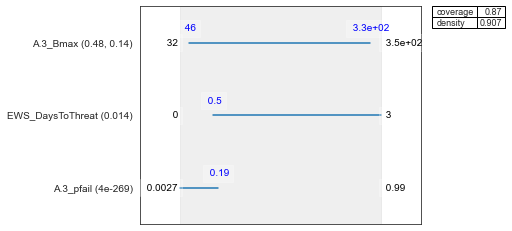

In [27]:
#--- Box 28 gives the highest density with coverage > 80%
box.inspect(28)
box.select(28)
box.inspect(style='graph')
plt.show()

In [28]:
#--- Save scenarios and outcomes of the box
scens_in_box = experiments.iloc[box.yi]
outcomes_in_box = {k:v[box.yi] for k,v in outcomes.items()}

# Step 3: Reference scenario selection
This step consists of finding the worst 5 scenarios regarding number of deaths and annual damage in Zutphen.

In [71]:
from ema_workbench import load_results

experiments, outcomes = load_results('Voila_my_results_Auriane.tar.gz')

#--- Finding the worst-case scenarios in deaths and damage in Zutphen
y = ((outcomes['A.3_Expected Annual Damage'] > np.percentile(outcomes['A.3_Expected Annual Damage'] , 98)) & (outcomes['A.3_Expected Number of Deaths'] > np.percentile(outcomes['A.3_Expected Number of Deaths'] , 98)))

[MainProcess/INFO] results loaded succesfully from /Users/auriane/OneDrive/Q4/MBDM/final assignment/Voila_my_results_Auriane.tar.gz


In [72]:
np.count_nonzero(y)

5

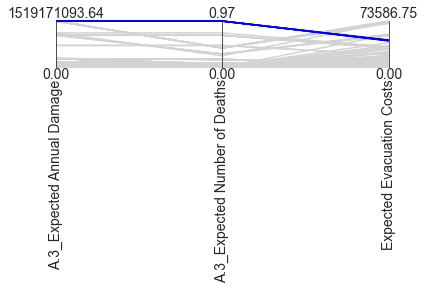

In [73]:
#--- Visualize the outcomes of these scenarios compared to the others

# conditional on y
data = pd.DataFrame({k:v[y] for k,v in outcomes.items()})
all_data = pd.DataFrame({k:v for k,v in outcomes.items()})

# Focus on Zutphen outcomes
selected_data = all_data[['A.3_Expected Annual Damage','A.3_Expected Number of Deaths','Expected Evacuation Costs']]
limits = parcoords.get_limits(selected_data)
axes = parcoords.ParallelAxes(limits)
axes.plot(all_data, color='lightgrey')
axes.plot(data, color='blue')
plt.show()

In [75]:
#--- Saving the worst-case scenarios for future use
from ema_workbench import Scenario

# Saving them in a data frame
indices = [i for i, x in enumerate(y) if x]
selected = experiments.loc[indices,:]
selected = selected.drop(columns = ['scenario','policy','model','A.3_Dike Investment Costs'])

# Turning the data frame into scenarios
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
35,68.0,125.337557,10.0,0.442291,238.106191,10.0,0.165455,46.77986,1.5,0.002725,...,4.0,1.0,0.0,0.0,5.0,2.0,2.0,7.0,0.0,1.0
107,68.0,125.337557,10.0,0.442291,238.106191,10.0,0.165455,46.77986,1.5,0.002725,...,7.0,1.0,0.0,0.0,6.0,7.0,4.0,7.0,5.0,2.0
179,68.0,125.337557,10.0,0.442291,238.106191,10.0,0.165455,46.77986,1.5,0.002725,...,2.0,1.0,0.0,0.0,5.0,7.0,1.0,9.0,5.0,3.0
233,68.0,125.337557,10.0,0.442291,238.106191,10.0,0.165455,46.77986,1.5,0.002725,...,7.0,1.0,0.0,0.0,9.0,4.0,7.0,6.0,5.0,6.0
269,68.0,125.337557,10.0,0.442291,238.106191,10.0,0.165455,46.77986,1.5,0.002725,...,7.0,1.0,0.0,0.0,6.0,3.0,4.0,6.0,5.0,4.0


# Step 4: Finding alternative solutions
This steps is identical to step 2.2, but for multiple reference scenarios. It thus consists of:
- searching for candidate solutions for each scenario through optimization
- visualizing the convergence of the algorithm (hypervolume and epsilon progress)
- visalizing the trade-offs in outcomes for all candidate solutionsover the scenarios


In [77]:
#--- Searching for candidate solutions for each scenario

def optimize(scenario, nfe, model, converge_metrics, epsilons):


    with MultiprocessingEvaluator(dike_model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
    return results, convergence


results = []
for scenario in scenarios:
    convergence_metrics = [HyperVolume(minimum=[0,0,0,0], maximum=[3, 2,1.01,1.01]),
                           EpsilonProgress()]
    epsilons = [0.1,]*len(dike_model.outcomes)
    
    results.append(optimize(scenario, 5000, dike_model, convergence_metrics, epsilons))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 997/5000 nfe
[MainProcess/INFO] generation 15: 1496/5000 nfe
[MainProcess/INFO] generation 20: 1994/5000 nfe
[MainProcess/INFO] generation 25: 2491/5000 nfe
[MainProcess/INFO] generation 30: 2990/5000 nfe
[MainProcess/INFO] generation 35: 3489/5000 nfe
[MainProcess/INFO] generation 40: 3987/5000 nfe
[MainProcess/INFO] generation 45: 4484/5000 nfe
[MainProcess/INFO] generation 50: 4978/5000 nfe
[MainProcess/INFO] optimization completed, found 147 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 499/5000 nfe
[MainProcess/INFO] generation 10: 998/5000 nfe
[MainProcess/INFO] generation 15: 1498/5000 nfe
[MainProcess/INFO] generation 20: 1993/5000 nfe
[MainProcess/INFO] generation 25: 2490/5000 nfe
[MainProcess/INFO] generation 30: 2

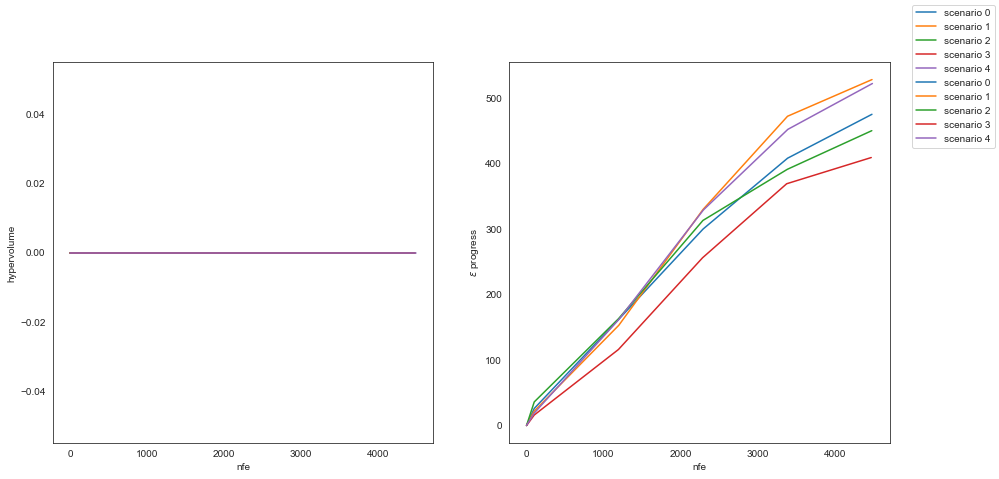

In [92]:
#--- Visualizing convergence
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,7))
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

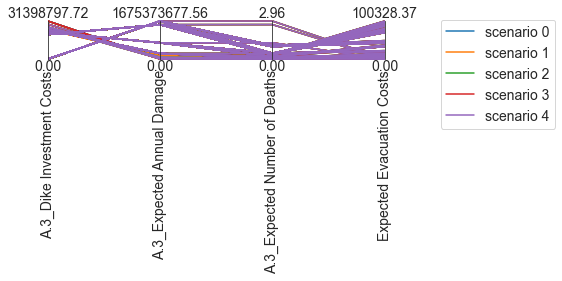

In [99]:
#--- Visualizing trade-offs in Zutphen's outcomes for all solutions
colors = iter(sns.color_palette())

data = results[0][0].iloc[:, 31::]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)


for i, (result, _) in enumerate(results):
    color = next(colors)
    data = result.iloc[:, 5::]
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
plt.show()

# Step 5: uncertainty analysis
This step is almost identical to step 2.3 and consists of the following actions:
- Run experiments for all candidate solutions
- Score the outcomes by their signal-to-noise ratio and maximum regret (new!)
- Visualize the scores for Zutphen's outcomes

In [102]:
#--- Run experiments for all sollutions

# Create list of policies to test
policies = []
for i, (result, _) in enumerate(results):
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)

# Run experiments
with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(10, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10 scenarios * 720 policies * 1 model(s) = 7200 experiments
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 2160 cases completed
[MainProcess/INFO] 2880 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4320 cases completed
[MainProcess/INFO] 5040 cases completed
[MainProcess/INFO] 5760 cases completed
[MainProcess/INFO] 6480 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


/Users/auriane/miniconda3/envs/gds/lib/python3.6/site-packages/ema_workbench/analysis/parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


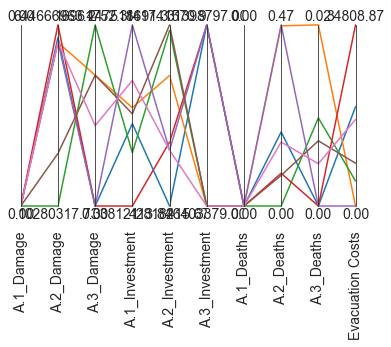

In [231]:
#--- Calculating and visualizing maximum regret
overall_scores = {}
regret = []

# Calculating regret
for scenario in experiments.scenario.unique():
    logical = experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = experiments[experiments.scenario==scenario]
        
    best = temp_results.min()
    scenario_regret = temp_results - best
    scenario_regret['policy'] = temp_experiments.policy.values    
    regret.append(scenario_regret)
    
regret = pd.concat(regret)
maxregret = regret.groupby('policy').max()
#data = maxregret.loc[:, [o for o in ['A.3_Expected Annual Damage', 'A.3_Expected Number of Deaths', 'A.3_Dike Investment Costs', 'Expected Evacuation Costs']]]
data = maxregret.loc[:, [o for o in ['A.1_Expected Annual Damage', 'A.2_Expected Annual Damage',
                                     'A.3_Expected Annual Damage', 'A.1_Dike Investment Costs',
                                     'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs',
                                     'A.1_Expected Number of Deaths','A.2_Expected Number of Deaths',
                                     'A.3_Expected Number of Deaths',
                                     'Expected Evacuation Costs']]]

data.rename(columns = {'A.1_Expected Annual Damage':'A.1_Damage',
                       'A.2_Expected Annual Damage':'A.2_Damage',
                       'A.3_Expected Annual Damage':'A.3_Damage',
                       'A.4_Expected Annual Damage':'A.4_Damage',
                       'A.5_Expected Annual Damage':'A.5_Damage',
                       'A.1_Expected Number of Deaths':'A.1_Deaths',
                       'A.2_Expected Number of Deaths':'A.2_Deaths',
                       'A.3_Expected Number of Deaths':'A.3_Deaths',
                       'A.4_Expected Number of Deaths':'A.4_Deaths',
                       'A.5_Expected Number of Deaths':'A.5_Deaths',
                       'A.1_Dike Investment Costs':'A.1_Investment',
                       'A.2_Dike Investment Costs':'A.2_Investment',
                       'A.3_Dike Investment Costs':'A.3_Investment',
                       'A.4_Dike Investment Costs':'A.4_Investment',
                       'A.5_Dike Investment Costs':'A.5_Investment',
                       'Expected Evacuation Costs':'Evacuation Costs'
                       }, 
                       inplace = True)

# Pre-filtering policies for clarity of the figure
#lowest 10% damage in A2 and A3
data = data.loc[data['A.3_Damage'] < np.percentile(data['A.3_Damage'], 10)]
data = data.loc[data['A.2_Damage'] < np.percentile(data['A.2_Damage'], 20)]
data = data.loc[data['A.1_Damage'] < np.percentile(data['A.1_Damage'], 60)]
data = data.loc[data['A.1_Deaths'] < 0.5]
data = data.loc[data['A.2_Deaths'] < 0.5]
data = data.loc[data['A.3_Deaths'] < 0.5]


paraxes = parcoords.ParallelAxes(data)
paraxes.plot(data)
plt.show()

In [282]:
#--- Identifying the red policy by its extreme values
print(data['A.2_Damage'].max())
print(data['Evacuation Costs'].max())

644666963.4382044
34808.86544063971


In [284]:
#--- Finding the policy 
y = ((outcomes['A.2_Expected Annual Damage']== 644666963.4382044) & (outcomes['Expected Evacuation Costs'] == 34808.86544063971))
indices = [i for i, x in enumerate(y) if x]
filtered_experiments = experiments.iloc[indices,30::]
filtered_experiments.head()

,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,A.3_Dike Investment Costs,A.3_Expected Annual Damage,A.3_Expected Number of Deaths,Expected Evacuation Costs
425,1.0,1.0,1.0,1.0,2.0,5.0,2.0,1.0,1.0,1.0,...,5.0,7.0,1.0,1220,scenario 0 option 42,dikesnet,0.0,1.673542e+09,0.443678,78311.922763
945,1.0,1.0,1.0,1.0,2.0,4.0,1.0,2.0,1.0,1.0,...,6.0,0.0,6.0,1220,scenario 0 option 94,dikesnet,22167818.0,7.143525e+08,0.189421,34283.363111
1335,1.0,1.0,1.0,1.0,2.0,6.0,10.0,9.0,1.0,1.0,...,4.0,0.0,5.0,1220,scenario 0 option 133,dikesnet,20299287.0,1.517339e+09,0.402272,71141.937717
1345,1.0,1.0,1.0,1.0,2.0,9.0,6.0,7.0,1.0,1.0,...,6.0,3.0,8.0,1220,scenario 0 option 134,dikesnet,24198032.0,2.424405e+08,0.064329,12621.737130
1775,1.0,1.0,1.0,1.0,2.0,5.0,4.0,9.0,1.0,1.0,...,8.0,6.0,2.0,1220,scenario 1 option 30,dikesnet,0.0,1.673542e+09,0.443678,78311.922763


In [281]:
policies, convergence = results[0]
policies.iloc[42,:]

0_RfR 0                          0.000000e+00
0_RfR 1                          1.000000e+00
0_RfR 2                          0.000000e+00
1_RfR 0                          1.000000e+00
1_RfR 1                          0.000000e+00
1_RfR 2                          1.000000e+00
2_RfR 0                          1.000000e+00
2_RfR 1                          1.000000e+00
2_RfR 2                          1.000000e+00
3_RfR 0                          1.000000e+00
3_RfR 1                          1.000000e+00
3_RfR 2                          1.000000e+00
4_RfR 0                          1.000000e+00
4_RfR 1                          1.000000e+00
4_RfR 2                          1.000000e+00
EWS_DaysToThreat                 2.000000e+00
A.1_DikeIncrease 0               5.000000e+00
A.1_DikeIncrease 1               2.000000e+00
A.1_DikeIncrease 2               1.000000e+00
A.2_DikeIncrease 0               1.000000e+00
A.2_DikeIncrease 1               1.000000e+00
A.2_DikeIncrease 2               0

# Step 6: Scenario discovery
Given that the chosen policy (red) yields such high damage in the second dike ring, said damage is the focus of this scenario discovery. This step is very similar to step 2.4.

In [302]:
experiments_reeval, outcomes_reeval = reeevaluation_results

y = outcomes['A.2_Expected Annual Damage'] > 6e8

# Prim only accepts up to 5000 rows
exp_short = experiments_reeval.iloc[0:4999,:]
x = exp_short
ind_pos = [i for i in range(0,4999)]
y = y[ind_pos]

prim_alg = prim.Prim(x,y, threshold=0.4)
box = prim_alg.find_box()
box.inspect_tradeoff()


[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 4999 points remaining, containing 232 cases of interest
[MainProcess/INFO] mean: 0.464, mass: 0.10002000400080016, coverage: 1.0, density: 0.464 restricted_dimensions: 3


alt.VConcatChart(...)